<a href="https://colab.research.google.com/github/james-yu2005/Affi-NN-ity/blob/main/PDB_Bind_v2_Affi_NN_ity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Drugs are encoded as character-level SMILES and proteins are encoded as sequence encoding
!pip install -q PyTDC rdkit-pypi torch-geometric pandas tqdm deepchem fair-esm biopython torch

In [2]:
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np
import os
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import deepchem as dc
from rdkit import RDLogger
import matplotlib.pyplot as plt
from collections import Counter
from Bio import PDB
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
tasks, datasets, transformers = dc.molnet.load_pdbbind(
    featurizer='raw',
    set_name='refined',
    splitter='random',
    reload=True
)
train_dataset, valid_dataset, test_dataset = datasets
print(f"Train dataset length: {len(train_dataset)}\nValidate dataset length: {len(valid_dataset)}\nTest dataset length: {len(test_dataset)}")

Train dataset length: 3881
Validate dataset length: 485
Test dataset length: 486


In [4]:
# Print out one example from training
for X, y, w, ids in train_dataset.iterbatches(batch_size=1, deterministic=True):
    print("Example of first datum from training :\n")
    print("Input features (X):", X)
    print("Binding affinity target label (y):", y)
    print("Weight (w):", w)
    print("Sample ID (ids):", ids)
    break

Example of first datum from training :

Input features (X): [['/tmp/refined-set/6czb/6czb_ligand.sdf'
  '/tmp/refined-set/6czb/6czb_pocket.pdb']]
Binding affinity target label (y): [-1.06034854]
Weight (w): [1.]
Sample ID (ids): ['6czb']


In [27]:
def remove_invalid_molecules(dc_dataset, dataset_name):
    valid_entries = []
    removed = 0
    for X, y, w, ids in dc_dataset.iterbatches(batch_size=1, deterministic=True):
      ligand_path = X[0][0]
      ligand_mol = Chem.MolFromMolFile(str(ligand_path))

      if ligand_mol is None:
        if str(dataset_name) == "train":
          removed += 1
        elif str(dataset_name) == "valid":
          removed += 1
        elif str(dataset_name) == "test":
          removed += 1
        continue

      valid_entries.append((X, y, w, ids))

    return valid_entries, removed

clean_train_dataset, train_removed = remove_invalid_molecules(train_dataset, "train")
clean_valid_dataset, valid_removed = remove_invalid_molecules(valid_dataset, "valid")
clean_test_dataset, test_removed = remove_invalid_molecules(test_dataset, "test")

print(f"New train dataset length: {len(clean_train_dataset)}. Removed molecules: {train_removed}\nNew validate dataset length: {len(clean_valid_dataset)}. Removed molecules: {valid_removed}\nNew test dataset length: {len(clean_test_dataset)}. Removed molecules: {test_removed}")

New train dataset length: 2566. Removed molecules: 1315
New validate dataset length: 322. Removed molecules: 163
New test dataset length: 318. Removed molecules: 168


In [6]:
def get_all_protein_lengths(dataset):
  parser = PDB.PDBParser(QUIET=True)
  molecule_protein_lengths = []
  for X, y, w, ids in dataset:
    protein_path = X[0][1]
    structure = parser.get_structure("protein", protein_path)
    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())
        length = len(str(sequence))
    molecule_protein_lengths.append(length)

  return molecule_protein_lengths

def get_all_ligand_lengths(dataset):
  molecule_ligand_lengths = []
  for X, y, w, ids in dataset:
    ligand_path = X[0][0]
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    ligand_smiles = Chem.MolToSmiles(ligand_mol)
    length = len(str(ligand_smiles))
    molecule_ligand_lengths.append(length)

  return molecule_ligand_lengths

ligand_train_length_dataset = get_all_ligand_lengths(clean_train_dataset)
ligand_valid_length_dataset = get_all_ligand_lengths(clean_valid_dataset)
ligand_test_length_dataset = get_all_ligand_lengths(clean_test_dataset)
protein_train_length_dataset = get_all_protein_lengths(clean_train_dataset)
protein_valid_length_dataset = get_all_protein_lengths(clean_valid_dataset)
protein_test_length_dataset = get_all_protein_lengths(clean_test_dataset)

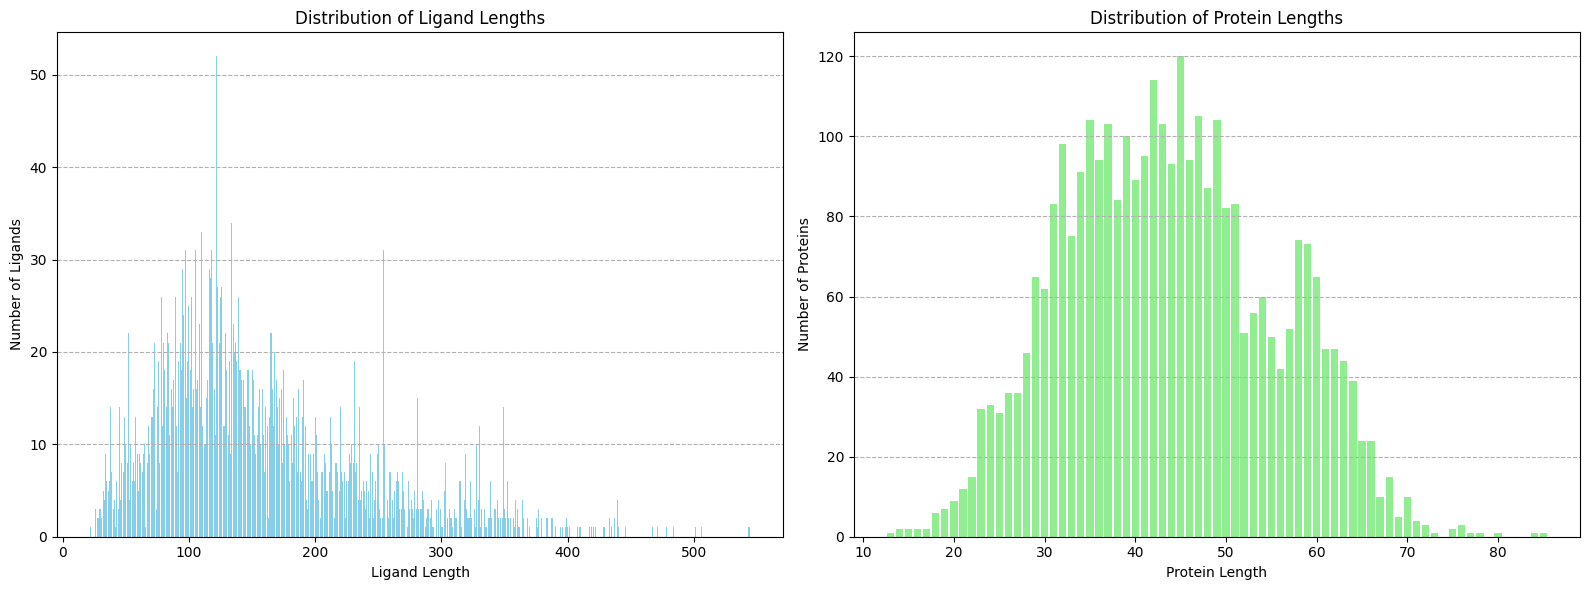

Max ligand length: 544
90% of ligands are shorter than or equal to: 275
Max protein length: 85
90% of proteins are shorter than or equal to: 60


In [7]:
# Combine all ligand lengths
all_ligand_lengths = ligand_train_length_dataset + ligand_valid_length_dataset + ligand_test_length_dataset
ligand_length_counts = Counter(all_ligand_lengths)
ligand_lengths = sorted(ligand_length_counts.keys())
ligand_counts = [ligand_length_counts[length] for length in ligand_lengths]

# Combine all protein lengths
all_protein_lengths = protein_train_length_dataset + protein_valid_length_dataset + protein_test_length_dataset
protein_length_counts = Counter(all_protein_lengths)
protein_lengths = sorted(protein_length_counts.keys())
protein_counts = [protein_length_counts[length] for length in protein_lengths]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Ligand plot
axs[0].bar(ligand_lengths, ligand_counts, color='skyblue')
axs[0].set_xlabel('Ligand Length')
axs[0].set_ylabel('Number of Ligands')
axs[0].set_title('Distribution of Ligand Lengths')
axs[0].grid(axis='y', linestyle='--')

# Protein plot
axs[1].bar(protein_lengths, protein_counts, color='lightgreen')
axs[1].set_xlabel('Protein Length')
axs[1].set_ylabel('Number of Proteins')
axs[1].set_title('Distribution of Protein Lengths')
axs[1].grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

# Stats for ligand
max_ligand = max(all_ligand_lengths)
ligand_cutoff = int(np.percentile(all_ligand_lengths, 90))
print(f"Max ligand length: {max_ligand}")
print(f"90% of ligands are shorter than or equal to: {ligand_cutoff}")

# Stats for protein
max_protein = max(all_protein_lengths)
protein_cutoff = int(np.percentile(all_protein_lengths, 90))
print(f"Max protein length: {max_protein}")
print(f"90% of proteins are shorter than or equal to: {protein_cutoff}")


In [11]:
import torch
import numpy as np
from rdkit import Chem
from torch_geometric.data import Data

def get_node_features(ligand_path):
    all_node_feats = []
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    for atom in ligand_mol.GetAtoms():
        node_feats = [
            atom.GetAtomicNum(),
            atom.GetDegree(),
            atom.GetFormalCharge(),
            int(atom.GetHybridization()),  # convert enum to int
            atom.GetIsAromatic(),
            atom.GetTotalNumHs(),
            atom.GetNumRadicalElectrons(),
            atom.IsInRing(),
            int(atom.GetChiralTag())  # convert enum to int
        ]
        all_node_feats.append(node_feats)
    return torch.tensor(all_node_feats, dtype=torch.float)

def get_edge_features(mol):
    all_edge_feats = []
    for bond in mol.GetBonds():
        edge_feats = [
            bond.GetBondTypeAsDouble(),
            bond.IsInRing(),
            bond.GetIsConjugated(),
            int(bond.GetStereo()),
            int(bond.GetBondDir())
        ]
        all_edge_feats += [edge_feats, edge_feats]  # Bidirectional edges
    return torch.tensor(all_edge_feats, dtype=torch.float)

def get_adjacency_info(mol):
    edge_indices = []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]  # Bidirectional edges
    return torch.tensor(edge_indices, dtype=torch.long).t().contiguous()


In [53]:
CHAR_SMI_SET = {"(": 1, ".": 2, "0": 3, "2": 4, "4": 5, "6": 6, "8": 7, "@": 8,
                "B": 9, "D": 10, "F": 11, "H": 12, "L": 13, "N": 14, "P": 15, "R": 16,
                "T": 17, "V": 18, "Z": 19, "\\": 20, "b": 21, "d": 22, "f": 23, "h": 24,
                "l": 25, "n": 26, "r": 27, "t": 28, "#": 29, "%": 30, ")": 31, "+": 32,
                "-": 33, "/": 34, "1": 35, "3": 36, "5": 37, "7": 38, "9": 39, "=": 40,
                "A": 41, "C": 42, "E": 43, "G": 44, "I": 45, "K": 46, "M": 47, "O": 48,
                "S": 49, "U": 50, "W": 51, "Y": 52, "[": 53, "]": 54, "a": 55, "c": 56,
                "e": 57, "g": 58, "i": 59, "m": 60, "o": 61, "s": 62, "u": 63, "y": 64}

def encode_ligands(ligand_path, max_smile_len=275):
    ligand_mol = Chem.MolFromMolFile(str(ligand_path))
    ligand_smiles = Chem.MolToSmiles(ligand_mol)
    encoded_ligand = np.zeros(max_smile_len)

    for i, ch in enumerate(ligand_smiles[:max_smile_len]):
        if ch in CHAR_SMI_SET:
            encoded_ligand[i] = CHAR_SMI_SET[ch] - 1
        else:
            encoded_ligand[i] = 0
    tensor_form = torch.tensor(encoded_ligand, dtype=torch.float)
    # padded = torch.nn.functional.pad(tensor_form, (0, 85))
    # reshaped = padded.view(40, 9)
    return tensor_form

ligand_1 = encode_ligands("/tmp/refined-set/6czb/6czb_ligand.sdf")
print(ligand_1.shape)


torch.Size([275])


In [21]:
def extract_sequence_from_pdb(pdb_path):
    """Extracts the amino acid sequence from a PDB file using Biopython."""
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    ppb = PDB.PPBuilder()
    sequence = ""
    for pp in ppb.build_peptides(structure):
        sequence += str(pp.get_sequence())

    return sequence

# Define amino acid to index mapping
aa_to_idx = {
    'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12,
    'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18,
    'W': 19, 'Y': 20  # Extend as needed
}

def encode_sequence(seq, aa_to_idx, max_len=60):
    seq_idx = [aa_to_idx.get(aa, 0) for aa in seq]  # 0 for unknowns
    if len(seq_idx) < max_len:
        seq_idx += [0] * (max_len - len(seq_idx))
    else:
        seq_idx = seq_idx[:max_len]
    return seq_idx


In [54]:
def process_deepchem_dataset(dataset):
    molecule_data = []

    for X, y, w, ids in dataset:
        ligand_path = X[0][0]
        protein_path = X[0][1]

        ligand_mol = Chem.MolFromMolFile(str(ligand_path))
        ligand_vector = encode_ligands(ligand_path)  # shape: [275]
        # node_feats = encode_ligands(ligand_path)
        # edge_feats = get_edge_features(ligand_mol)
        # edge_index = get_adjacency_info(ligand_mol)

        protein_sequence = extract_sequence_from_pdb(protein_path)
        target_features = encode_sequence(protein_sequence, aa_to_idx)
        target_features = torch.tensor(target_features, dtype=torch.long)

        data = Data(
            # x=node_feats,
            # edge_index=edge_index,
            # edge_attr=edge_feats,
            ligand_vector=ligand_vector,
            y=torch.tensor(y, dtype=torch.float)
        )
        data.target_features = target_features

        molecule_data.append(data)

    return molecule_data

In [55]:
train_graphs = process_deepchem_dataset(clean_train_dataset)
valid_graphs = process_deepchem_dataset(clean_valid_dataset)
test_graphs = process_deepchem_dataset(clean_test_dataset)

# Create DataLoaders
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

print(len(train_graphs))
print(len(valid_graphs))
print(len(test_graphs))

2566
322
318


In [60]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.loader import DataLoader

class LigandVectorTargetModel(torch.nn.Module):
    def __init__(self, ligand_feat_dim=275, pocket_feat_dim=60, hidden_dim=128, output_dim=1):
        super(LigandVectorTargetModel, self).__init__()

        self.ligand_embedding = Sequential(
            Linear(ligand_feat_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

        self.pocket_embedding = Sequential(
            Linear(pocket_feat_dim, hidden_dim),
            ReLU(),
            Dropout(0.1),
            Linear(hidden_dim, hidden_dim),
            ReLU(),
            Linear(hidden_dim, hidden_dim)
        )

        self.predictor = Sequential(
            Linear(2 * hidden_dim, hidden_dim),
            ReLU(),
            Dropout(0.2),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, batch):
        # Get batch size from y
        batch_size = batch.y.size(0)

        # Reshape ligand features
        ligand_feat = batch.ligand_vector.float()
        if ligand_feat.dim() == 1:
            # If flattened, reshape to [batch_size, features_per_sample]
            ligand_feat_dim = ligand_feat.size(0) // batch_size
            ligand_feat = ligand_feat.view(batch_size, ligand_feat_dim)

        # Reshape target features
        pocket_feat = batch.target_features.float()
        if pocket_feat.dim() == 1:
            # If flattened, reshape to [batch_size, features_per_sample]
            pocket_feat_dim = pocket_feat.size(0) // batch_size
            pocket_feat = pocket_feat.view(batch_size, pocket_feat_dim)

        print(f"After reshape - Ligand: {ligand_feat.shape}, Target: {pocket_feat.shape}")

        ligand_emb = self.ligand_embedding(ligand_feat)
        pocket_emb = self.pocket_embedding(pocket_feat)

        combined = torch.cat([ligand_emb, pocket_emb], dim=1)
        result = self.predictor(combined)
        return result

def debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=40, lr=0.001, device='cpu'):
    print(f"Using device: {device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0

    # Get dimensions from first batch
    first_batch = next(iter(train_loader))
    batch_size = first_batch.y.size(0)
    ligand_dim = first_batch.ligand_vector.size(0) // batch_size
    target_dim = first_batch.target_features.size(0) // batch_size

    print(f"Detected dimensions - Batch size: {batch_size}, Ligand: {ligand_dim}, Target: {target_dim}")

    # Recreate model with correct dimensions
    model = LigandVectorTargetModel(ligand_feat_dim=ligand_dim, pocket_feat_dim=target_dim)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_losses = []

        for i, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()

            try:
                preds = model(batch).squeeze()
                targets = batch.y.squeeze().float().to(device)

                # Handle dimension mismatch
                if preds.dim() == 0:
                    preds = preds.unsqueeze(0)
                if targets.dim() == 0:
                    targets = targets.unsqueeze(0)

                loss = F.mse_loss(preds, targets)
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            except Exception as e:
                print(f"Error in training batch {i}: {e}")
                print(f"Ligand shape: {batch.ligand_vector.shape}")
                print(f"Target shape: {batch.target_features.shape}")
                print(f"Y shape: {batch.y.shape}")
                return model

        if not train_losses:
            print("No successful training batches")
            break

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                try:
                    preds = model(batch).squeeze()
                    targets = batch.y.squeeze().float().to(device)

                    # Handle dimension mismatch
                    if preds.dim() == 0:
                        preds = preds.unsqueeze(0)
                    if targets.dim() == 0:
                        targets = targets.unsqueeze(0)

                    loss = F.mse_loss(preds, targets)
                    val_losses.append(loss.item())
                except:
                    continue

        if not val_losses:
            print("No successful validation batches")
            break

        train_loss_avg = sum(train_losses) / len(train_losses)
        val_loss_avg = sum(val_losses) / len(val_losses)

        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                return model

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

    return model

# This will automatically detect the right dimensions and create the model
model = LigandVectorTargetModel()  # Placeholder - will be recreated in training function
debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=40, device='cpu')

Streaming output truncated to the last 5000 lines.
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([3

In [43]:
# import torch
# import torch.nn.functional as F
# from torch.nn import Linear, ReLU, Sequential, BatchNorm1d, Dropout
# from torch_geometric.nn import GINConv, global_add_pool
# from torch_geometric.loader import DataLoader

# class GINDrugTargetModel(torch.nn.Module):
#     def __init__(self, node_feat_dim=11, pocket_feat_dim=60, hidden_dim=128, output_dim=1):
#         super(GINDrugTargetModel, self).__init__()
#         self.node_embedding = Sequential(
#             Linear(node_feat_dim, hidden_dim),
#             ReLU(),
#             Linear(hidden_dim, hidden_dim)
#         )
#         nn1 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
#         self.conv1 = GINConv(nn1)
#         self.bn1 = BatchNorm1d(hidden_dim)
#         nn2 = Sequential(Linear(hidden_dim, hidden_dim), ReLU(), Linear(hidden_dim, hidden_dim))
#         self.conv2 = GINConv(nn2)
#         self.bn2 = BatchNorm1d(hidden_dim)
#         self.pocket_embedding = Sequential(
#             Linear(pocket_feat_dim, hidden_dim),
#             ReLU(),
#             Dropout(0.1),
#             Linear(hidden_dim, hidden_dim),
#             ReLU(),
#             Linear(hidden_dim, hidden_dim)
#         )
#         self.predictor = Sequential(
#             Linear(2 * hidden_dim, hidden_dim),
#             ReLU(),
#             Dropout(0.2),
#             Linear(hidden_dim, hidden_dim // 2),
#             ReLU(),
#             Linear(hidden_dim // 2, output_dim)
#         )

#     def forward(self, batch):
#       x = self.node_embedding(batch.x)
#       x = F.relu(self.conv1(x, batch.edge_index))
#       x = self.bn1(x)
#       x = F.relu(self.conv2(x, batch.edge_index))
#       x = self.bn2(x)
#       mol_emb = global_add_pool(x, batch.batch)
#       pocket_features = batch.target_features.float()
#       pocket_emb = self.pocket_embedding(pocket_features)
#       combined = torch.cat([mol_emb, pocket_emb], dim=1)
#       result = self.predictor(combined)
#       return result

# def debug_train_model(model, train_loader, val_loader, num_epochs=1, patience=40, lr=0.001, device='cpu'):
#     print(f"Using device: {device}")
#     model = model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     best_val_loss = float('inf')
#     patience_counter = 0

#     for epoch in range(num_epochs):
#         model.train()
#         train_losses = []

#         for i, batch in enumerate(train_loader):
#             batch = batch.to(device)
#             optimizer.zero_grad()
#             preds = model(batch).squeeze()
#             targets = batch.y.squeeze().float().to(device)
#             loss = F.mse_loss(preds, targets)
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())

#         model.eval()
#         val_losses = []
#         with torch.no_grad():
#             for batch in val_loader:
#                 batch = batch.to(device)
#                 preds = model(batch).squeeze()
#                 targets = batch.y.squeeze().float().to(device)
#                 loss = F.mse_loss(preds, targets)
#                 val_losses.append(loss.item())

#         train_loss_avg = sum(train_losses) / len(train_losses)
#         val_loss_avg = sum(val_losses) / len(val_losses)

#         if val_loss_avg < best_val_loss:
#           best_val_loss = val_loss_avg
#           patience_counter = 0
#         else:
#           patience_counter += 1
#           if patience_counter >= patience:
#             print("Early stopping triggered.")
#             return model

#         print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f} - Val Loss: {val_loss_avg:.4f}")

#     return model

# model = GINDrugTargetModel(node_feat_dim=9, pocket_feat_dim=60)
# debug_model = debug_train_model(model, train_loader, val_loader, num_epochs=200, patience=40,device='cpu')


Using device: cpu


IndexError: Found indices in 'edge_index' that are larger than 1279 (got 1289). Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 1280) in your node feature matrix and try again.

In [14]:
# torch.save(model.state_dict(), 'model_weights.pth')
# import pickle

# # Save model's state_dict
# with open('model_weights.pkl', 'wb') as f:
#     pickle.dump(model.state_dict(), f)

In [61]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, loader, device='cpu'):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Ensure predictions and targets are at least 1D arrays
            if preds.ndim == 0:
              preds = np.array([preds])
            if targets.ndim == 0:
              targets = np.array([targets])

            predictions.extend(preds)
            actuals.extend(targets)

    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals, predictions)

    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R-squared: {r2:.4f}")

    return mse, rmse, r2

print("Evaluating on Test Set:")
test_mse, test_rmse, test_r2 = evaluate_model(debug_model, test_loader, device='cpu')

Evaluating on Test Set:
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([30, 275]), Target: torch.Size([30, 60])
  MSE: 0.5859
  RMSE: 0.7655
  R-squared: 0.4790


After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([32, 275]), Target: torch.Size([32, 60])
After reshape - Ligand: torch.Size([30, 275]), Target: torch.Size([30, 60])


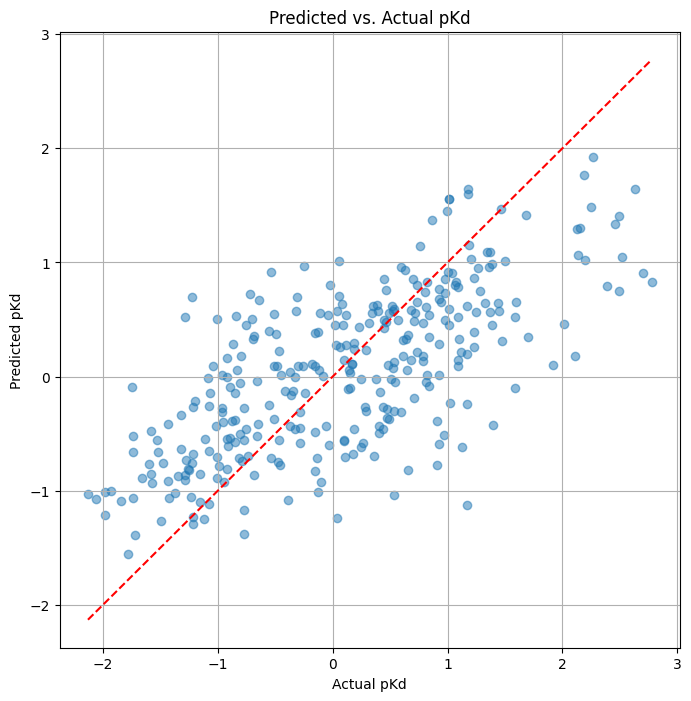

In [62]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions_vs_actual(model, loader, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch).squeeze().cpu().numpy()
            targets = batch.y.squeeze().cpu().numpy()

            # Handle cases where preds or targets might be single values
            if preds.ndim == 0:
                preds = np.array([preds])
            if targets.ndim == 0:
                targets = np.array([targets])

            all_preds.extend(preds)
            all_targets.extend(targets)

    plt.figure(figsize=(8, 8))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Actual pKd")
    plt.ylabel("Predicted pKd")
    plt.title("Predicted vs. Actual pKd")
    plt.grid(True)

    # Add a diagonal line for perfect prediction
    min_val = min(min(all_targets), min(all_preds))
    max_val = max(max(all_targets), max(all_preds))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.show()

# Use the trained model (debug_model) and the test_loader
plot_predictions_vs_actual(debug_model, test_loader, device='cpu')
